In [1]:
# Label Distribution Smoothing

In [2]:
!pip install -q wget japanize-matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# 必要ライブラリのインポート
import pandas as pd
import seaborn as sns
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import wget
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from scipy.ndimage import gaussian_filter1d, convolve1d
japanize_matplotlib.japanize()

In [4]:
# データセットのダウンロード
wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/00618/Steel_industry_data.csv")

'Steel_industry_data.csv'

In [6]:
original_df = pd.read_csv("Steel_industry_data.csv")
original_df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [7]:
# カラムを日本語に変更
original_df.columns = [
    '観測日時',
    '使用電力量(kWh)',
    '遅れ無効電力(kVarh)', # 負荷と電源で往復するだけで消費されない電力量のうち、インダクタンスに起因するもの．単位はキロバール時．
    '進み無効電力(kVarh)', # 負荷と電源で往復するだけで消費されない電力量のうち、静電容量に起因するもの．単位はキロバール時． 
    'CO2排出量(ppm)',
    '遅れ力率(%)', # 電流の位相遅れによって、実際には何割の電力しか使えていないのかを表す割合
    '進み力率(%)', # 電流の位相進みによって、実際には何割の電力しか使えていないのかを表す割合
    '深夜0時からの秒数',
    '平日か週末か',
    '曜日',
    '負荷の強さ'
]

In [14]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   観測日時           35040 non-null  object 
 1   使用電力量(kWh)     35040 non-null  float64
 2   遅れ無効電力(kVarh)  35040 non-null  float64
 3   進み無効電力(kVarh)  35040 non-null  float64
 4   CO2排出量(ppm)    35040 non-null  float64
 5   遅れ力率(%)        35040 non-null  float64
 6   進み力率(%)        35040 non-null  float64
 7   深夜0時からの秒数      35040 non-null  int64  
 8   平日か週末か         35040 non-null  object 
 9   曜日             35040 non-null  object 
 10  負荷の強さ          35040 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 2.9+ MB


In [15]:
# 観測日時を日付型に変換
original_df["観測日時"] = pd.to_datetime(original_df["観測日時"], format="%d/%m/%Y %H:%M")

# 観測日時をデータフレームのインデックスに指定
original_df = original_df.set_index("観測日時")

# 15分刻みでデータを作成（データが存在しない日時を欠損とする）
original_df = original_df.asfreq(freq="15min")
original_df.head()

,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,平日か週末か,曜日,負荷の強さ
観測日時,,,,,,,,,,
2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load


In [16]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2018-01-01 00:00:00 to 2018-12-31 23:45:00
Freq: 15T
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   使用電力量(kWh)     35040 non-null  float64
 1   遅れ無効電力(kVarh)  35040 non-null  float64
 2   進み無効電力(kVarh)  35040 non-null  float64
 3   CO2排出量(ppm)    35040 non-null  float64
 4   遅れ力率(%)        35040 non-null  float64
 5   進み力率(%)        35040 non-null  float64
 6   深夜0時からの秒数      35040 non-null  int64  
 7   平日か週末か         35040 non-null  object 
 8   曜日             35040 non-null  object 
 9   負荷の強さ          35040 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.9+ MB


In [18]:
# インデックスを振り直す
original_df = original_df.reset_index()
original_df.head()

,index,観測日時,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,平日か週末か,曜日,負荷の強さ
0,0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load
1,1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2,2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
3,3,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
4,4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load


In [20]:
# 使用電力量列を小数点以下３桁目で四捨五入
original_df["使用電力量（kWh）"] = original_df["使用電力量(kWh)"].round(decimals=2)

In [21]:
# 使用電力量列を下に4つずらした新しい列を作成(これが目的変数)
target = original_df["使用電力量（kWh）"].shift(-4)
print(target)

0        3.31
1        3.82
2        3.28
3        3.60
4        3.60
         ... 
35035    3.78
35036     NaN
35037     NaN
35038     NaN
35039     NaN
Name: 使用電力量（kWh）, Length: 35040, dtype: float64


In [25]:
# 列名を変更
target.name = "1時間後の使用電力量（kWh）"
print(target[:5])

0    3.31
1    3.82
2    3.28
3    3.60
4    3.60
Name: 1時間後の使用電力量（kWh）, dtype: float64


In [26]:
# 元データと目的変数を結合
df = pd.concat([original_df, target], axis=1)

# 最後の１０件を確認
df.tail(10)

,index,観測日時,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,平日か週末か,曜日,負荷の強さ,使用電力量（kWh）,1時間後の使用電力量（kWh）
35030,35030,2018-12-31 21:30:00,3.49,0.00,13.36,0.0,100.00,25.27,77400,Weekday,Monday,Light_Load,3.49,3.67
35031,35031,2018-12-31 21:45:00,3.42,0.00,13.36,0.0,100.00,24.80,78300,Weekday,Monday,Light_Load,3.42,3.82
35032,35032,2018-12-31 22:00:00,3.42,0.00,13.07,0.0,100.00,25.31,79200,Weekday,Monday,Light_Load,3.42,3.85
35033,35033,2018-12-31 22:15:00,3.24,3.38,0.22,0.0,69.20,99.77,80100,Weekday,Monday,Light_Load,3.24,3.74
35034,35034,2018-12-31 22:30:00,3.67,4.43,0.00,0.0,63.80,100.00,81000,Weekday,Monday,Light_Load,3.67,3.78
35035,35035,2018-12-31 22:45:00,3.82,4.54,0.00,0.0,64.38,100.00,81900,Weekday,Monday,Light_Load,3.82,3.78
35036,35036,2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load,3.85,NaN
35037,35037,2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load,3.74,NaN
35038,35038,2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load,3.78,NaN
35039,35039,2018-12-31 23:45:00,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load,3.78,NaN


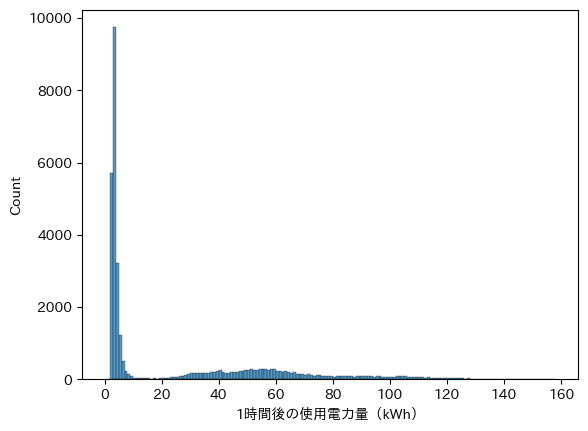

In [28]:
# 目的変数のヒストグラム確認
sns.histplot(data=df,
             x="1時間後の使用電力量（kWh）",
             binwidth=1)
plt.show()

In [29]:
# 使用電力量からラグ特徴量を作成し、部分時系列データに変換する関数
def add_lag_features(df,
                     num_lags=4, #  何時刻前のデータまで使用するか？
                     col_name="使用電力量(kWh)"
                     ):
    tmp_df = df.copy()
    # num_lagsの数だけラグ特徴量を作成
    for i in range(num_lags):
        shift_col = tmp_df[col_name].shift(i + 1)
        shift_col.name = f'{15 * (i + 1)}分前の' + col_name

        # 作成したラグ特徴量をデータフレームの新たな列に追加
        tmp_df = pd.concat([tmp_df, shift_col], axis=1)
    
    # ラグ特徴量を結合したデータフレームを返す
    return tmp_df

In [31]:
add_lag_df = add_lag_features(df)

add_lag_df.head(5)

,index,観測日時,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,平日か週末か,曜日,負荷の強さ,使用電力量（kWh）,1時間後の使用電力量（kWh）,15分前の使用電力量(kWh),30分前の使用電力量(kWh),45分前の使用電力量(kWh),60分前の使用電力量(kWh)
0,0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load,3.42,3.31,NaN,NaN,NaN,NaN
1,1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,3.17,3.82,3.42,NaN,NaN,NaN
2,2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,4.00,3.28,3.17,3.42,NaN,NaN
3,3,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load,3.24,3.60,4.00,3.17,3.42,NaN
4,4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load,3.31,3.60,3.24,4.00,3.17,3.42


In [32]:
# 欠損地が含まれる行の削除
removed_nan_df = add_lag_df.dropna()

# カテゴリ変数をワンホットベクトルに変換
onehot_df = pd.get_dummies(removed_nan_df)

onehot_df.head()

,index,観測日時,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,使用電力量（kWh）,1時間後の使用電力量（kWh）,15分前の使用電力量(kWh),30分前の使用電力量(kWh),45分前の使用電力量(kWh),60分前の使用電力量(kWh),平日か週末か_Weekday,平日か週末か_Weekend,曜日_Friday,曜日_Monday,曜日_Saturday,曜日_Sunday,曜日_Thursday,曜日_Tuesday,曜日_Wednesday,負荷の強さ_Light_Load,負荷の強さ_Maximum_Load,負荷の強さ_Medium_Load
4,4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,3.31,3.60,3.24,4.00,3.17,3.42,1,0,0,1,0,0,0,0,0,1,0,0
5,5,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,3.82,3.28,3.31,3.24,4.00,3.17,1,0,0,1,0,0,0,0,0,1,0,0
6,6,2018-01-01 01:30:00,3.28,3.56,0.0,0.0,67.76,100.0,5400,3.28,3.78,3.82,3.31,3.24,4.00,1,0,0,1,0,0,0,0,0,1,0,0
7,7,2018-01-01 01:45:00,3.60,4.14,0.0,0.0,65.62,100.0,6300,3.60,3.46,3.28,3.82,3.31,3.24,1,0,0,1,0,0,0,0,0,1,0,0
8,8,2018-01-01 02:00:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,3.60,3.24,3.60,3.28,3.82,3.31,1,0,0,1,0,0,0,0,0,1,0,0


In [33]:
# データの分割
train_df = onehot_df[onehot_df["観測日時"] < dt.datetime(2018, 12, 1, 0 ,0)]

test_df = onehot_df[onehot_df["観測日時"] >= dt.datetime(2018, 12, 1, 0, 0)]

In [34]:
train_df.head()

,index,観測日時,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,使用電力量（kWh）,1時間後の使用電力量（kWh）,15分前の使用電力量(kWh),30分前の使用電力量(kWh),45分前の使用電力量(kWh),60分前の使用電力量(kWh),平日か週末か_Weekday,平日か週末か_Weekend,曜日_Friday,曜日_Monday,曜日_Saturday,曜日_Sunday,曜日_Thursday,曜日_Tuesday,曜日_Wednesday,負荷の強さ_Light_Load,負荷の強さ_Maximum_Load,負荷の強さ_Medium_Load
4,4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,3.31,3.60,3.24,4.00,3.17,3.42,1,0,0,1,0,0,0,0,0,1,0,0
5,5,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,3.82,3.28,3.31,3.24,4.00,3.17,1,0,0,1,0,0,0,0,0,1,0,0
6,6,2018-01-01 01:30:00,3.28,3.56,0.0,0.0,67.76,100.0,5400,3.28,3.78,3.82,3.31,3.24,4.00,1,0,0,1,0,0,0,0,0,1,0,0
7,7,2018-01-01 01:45:00,3.60,4.14,0.0,0.0,65.62,100.0,6300,3.60,3.46,3.28,3.82,3.31,3.24,1,0,0,1,0,0,0,0,0,1,0,0
8,8,2018-01-01 02:00:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,3.60,3.24,3.60,3.28,3.82,3.31,1,0,0,1,0,0,0,0,0,1,0,0


In [37]:
# LDSによるデータの重みの計算
# 0~1の範囲で正規化されたカーネルを作成する関数
def create_gaussian_kernel(kernel_size,
                           sigma
                           ):
    half_kernel_size = (kernel_size - 1) // 2
    # 中心が１、それ以外を０としたベースカーネルを作成
    base_kernel = [0.] * half_kernel_size + [1.] + [0.] * half_kernel_size
    gaussian_kernel = gaussian_filter1d(base_kernel, sigma=sigma)
    normalized_gaussian_kernel = gaussian_kernel / gaussian_kernel.max()
    return normalized_gaussian_kernel

In [38]:
kernel_size = 5
# カーネルのハイパーパラメータ
sigma = 2
normalized_gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)
# カーネルを表示
normalized_gaussian_kernel

array([0.85828524, 0.94582765, 1.        , 0.94582765, 0.85828524])

In [45]:
def count_data_num_per_freq(df,
                            freq, # 目的変数値の粒度
                            label_col_name):
    value_count = {np.round(i, decimals=2): 0 for i in np.arange(df[label_col_name].min(),
                                                                 onehot_df[label_col_name].max() + freq,
                                                                 freq) }
    
    # 目的変数値ごとにデータ件数を集計
    for obj_val in df[label_col_name]:
        value_count[obj_val] += 1

    # 目的変数値と件数の組をNumpy配列として整理
    count_array = np.array([list(value_count.keys()), list(value_count.values())]).T
    # numpy配列をデータフレームに変換する
    counts = pd.DataFrame(count_array, columns=["目的変数値", "データ数"])
    # 作成したデータフレームを返す
    return counts

In [46]:
count_df = count_data_num_per_freq(df=train_df, freq=0.01, label_col_name="1時間後の使用電力量（kWh）")
count_df

,目的変数値,データ数
0,0.00,1.0
1,0.01,0.0
2,0.02,0.0
3,0.03,0.0
4,0.04,0.0
...,...,...
15714,157.14,0.0
15715,157.15,0.0
15716,157.16,0.0
15717,157.17,0.0


In [47]:
smooth_count = convolve1d(count_df["データ数"].to_numpy(), normalized_gaussian_kernel, mode="constant")
count_df["スムージングしたデータ数"] = smooth_count
count_df["各目的変数値ごとの重み"] = 1 / smooth_count

count_df

<ipython-input-47-d4580e3daf30>:3: RuntimeWarning: divide by zero encountered in true_divide
  count_df["各目的変数値ごとの重み"] = 1 / smooth_count


,目的変数値,データ数,スムージングしたデータ数,各目的変数値ごとの重み
0,0.00,1.0,1.000000,1.000000
1,0.01,0.0,0.945828,1.057275
2,0.02,0.0,0.858285,1.165114
3,0.03,0.0,0.000000,inf
4,0.04,0.0,0.000000,inf
...,...,...,...,...
15714,157.14,0.0,0.000000,inf
15715,157.15,0.0,0.000000,inf
15716,157.16,0.0,0.858285,1.165114
15717,157.17,0.0,0.945828,1.057275


In [49]:
# 上記データフレームを訓練データと結合する
concat_weight_train_df = pd.merge(
    left=train_df,
    right=count_df,
    left_on="1時間後の使用電力量（kWh）",
    right_on="目的変数値",
    how="left" #左外部結合
)

In [51]:
concat_weight_train_df.head()

,index,観測日時,使用電力量(kWh),遅れ無効電力(kVarh),進み無効電力(kVarh),CO2排出量(ppm),遅れ力率(%),進み力率(%),深夜0時からの秒数,使用電力量（kWh）,1時間後の使用電力量（kWh）,15分前の使用電力量(kWh),30分前の使用電力量(kWh),45分前の使用電力量(kWh),60分前の使用電力量(kWh),平日か週末か_Weekday,平日か週末か_Weekend,曜日_Friday,曜日_Monday,曜日_Saturday,曜日_Sunday,曜日_Thursday,曜日_Tuesday,曜日_Wednesday,負荷の強さ_Light_Load,負荷の強さ_Maximum_Load,負荷の強さ_Medium_Load,目的変数値,データ数,スムージングしたデータ数,各目的変数値ごとの重み
0,4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,3.31,3.60,3.24,4.00,3.17,3.42,1,0,0,1,0,0,0,0,0,1,0,0,3.60,351.0,351.0,0.002849
1,5,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,3.82,3.28,3.31,3.24,4.00,3.17,1,0,0,1,0,0,0,0,0,1,0,0,3.28,305.0,305.0,0.003279
2,6,2018-01-01 01:30:00,3.28,3.56,0.0,0.0,67.76,100.0,5400,3.28,3.78,3.82,3.31,3.24,4.00,1,0,0,1,0,0,0,0,0,1,0,0,3.78,225.0,225.0,0.004444
3,7,2018-01-01 01:45:00,3.60,4.14,0.0,0.0,65.62,100.0,6300,3.60,3.46,3.28,3.82,3.31,3.24,1,0,0,1,0,0,0,0,0,1,0,0,3.46,273.0,273.0,0.003663
4,8,2018-01-01 02:00:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,3.60,3.24,3.60,3.28,3.82,3.31,1,0,0,1,0,0,0,0,0,1,0,0,3.24,313.0,313.0,0.003195


In [53]:
X_train = concat_weight_train_df.drop(["観測日時",
                                       "1時間後の使用電力量（kWh）",
                                       "目的変数値",
                                       "データ数",
                                       "スムージングしたデータ数",
                                       "各目的変数値ごとの重み"], axis=1)

y_train = concat_weight_train_df["1時間後の使用電力量（kWh）"]
sample_weight = concat_weight_train_df["各目的変数値ごとの重み"]

In [54]:
regressor_normal = LGBMRegressor(random_state=1234) # LDSによる重みなし
regressor_LDS = LGBMRegressor(random_state=1234) # LDSによる重みあり

In [55]:
regressor_normal.fit(X_train,
                     y_train)
regressor_LDS.fit(X_train,
                  y_train,
                  sample_weight=sample_weight)

LGBMRegressor(random_state=1234)

In [62]:
test_df.columns

Index(['index', '観測日時', '使用電力量(kWh)', '遅れ無効電力(kVarh)', '進み無効電力(kVarh)',
       'CO2排出量(ppm)', '遅れ力率(%)', '進み力率(%)', '深夜0時からの秒数', '使用電力量（kWh）',
       '1時間後の使用電力量（kWh）', '15分前の使用電力量(kWh)', '30分前の使用電力量(kWh)',
       '45分前の使用電力量(kWh)', '60分前の使用電力量(kWh)', '平日か週末か_Weekday',
       '平日か週末か_Weekend', '曜日_Friday', '曜日_Monday', '曜日_Saturday', '曜日_Sunday',
       '曜日_Thursday', '曜日_Tuesday', '曜日_Wednesday', '負荷の強さ_Light_Load',
       '負荷の強さ_Maximum_Load', '負荷の強さ_Medium_Load'],
      dtype='object')

In [65]:
X_test = test_df.drop(["観測日時","1時間後の使用電力量（kWh）"], axis=1)
y_test = test_df["1時間後の使用電力量（kWh）"]

In [66]:
# LDSによる重みなしのモデルで予測
y_pred_normal = regressor_normal.predict(X_test)

# 重みありのモデルで予測
y_pred_LDS = regressor_LDS.predict(X_test)

In [67]:
mae_normal = mean_absolute_error(y_true=y_test, y_pred=y_pred_normal)

mae_LDS = mean_absolute_error(y_true=y_test, y_pred=y_pred_LDS)

print(mae_normal)
print(mae_LDS)

5.13365593149569
8.69424442933825


<Axes: xlabel='1時間後の使用電力量（kWh）', ylabel='1時間後の使用電力量（kWh）'>

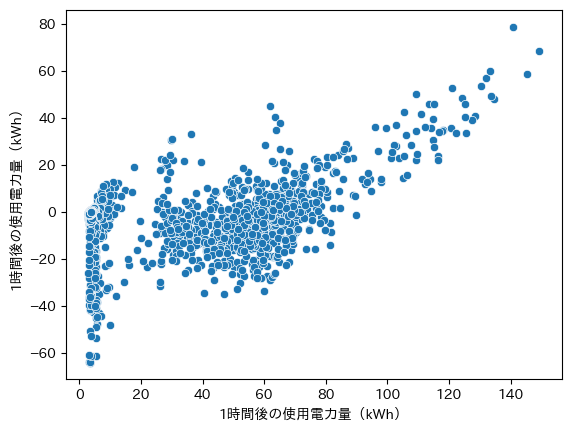

In [68]:
# 残差プロット
sns.scatterplot(x=y_test, y=y_test - y_pred_normal)

<Axes: xlabel='1時間後の使用電力量（kWh）', ylabel='1時間後の使用電力量（kWh）'>

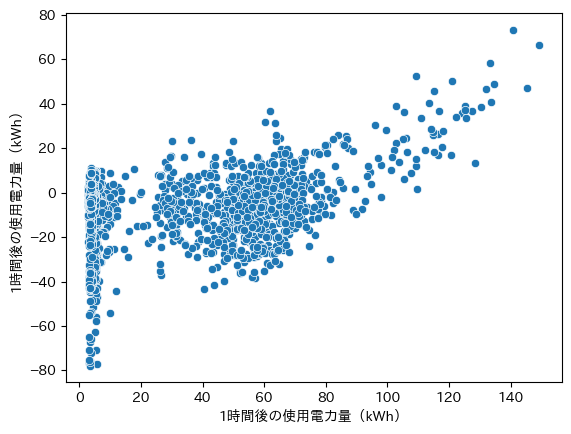

In [70]:
# LDSによる重みあり
sns.scatterplot(x=y_test, y=y_test - y_pred_LDS)